In [2]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [3]:
import topas2numpy
import tigre

In [4]:
# !rename -e 's/\d+/sprintf("%03d",$&)/e' -- ../batch_submission_smaller/*.csv

In [5]:
import glob

files = sorted(glob.glob('../batch_submission_smaller/*.csv'))

In [6]:
flood = topas2numpy.BinnedResult('Readout_flood.csv').data['Sum'].squeeze().T

<IPython.core.display.Javascript object>


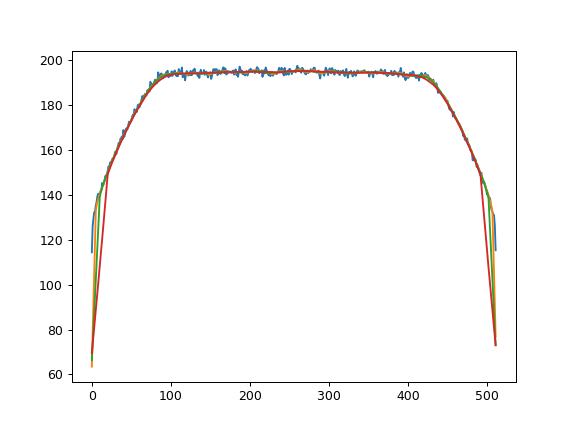

<IPython.core.display.Javascript object>


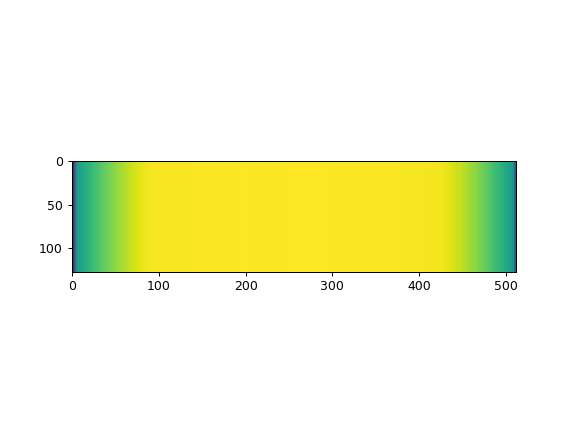

In [10]:
plt.figure()
plt.plot(np.mean(flood,0))

plt.plot(np.convolve(np.mean(flood,0),10*[0.1],mode='same'))
plt.plot(np.convolve(np.mean(flood,0),20*[0.05],mode='same'))
plt.plot(np.convolve(np.mean(flood,0),40*[0.025],mode='same'))

new_flood = np.convolve(np.mean(flood,0),40*[0.025],mode='same')

new_flood[:106] = np.convolve(np.mean(flood,0),10*[0.1],mode='same')[:106]
new_flood[415:] = np.convolve(np.mean(flood,0),10*[0.1],mode='same')[415:]

plt.figure()
plt.imshow(np.tile(new_flood,[128,1]))

In [11]:
images = np.zeros([180,128,512])

for ii, file in enumerate(files):
    
    print(file)
    
    images[ii] = -np.log(topas2numpy.BinnedResult(file).data['Sum'].squeeze().T/new_flood)

../batch_submission_smaller/Readout_000.csv
../batch_submission_smaller/Readout_002.csv
../batch_submission_smaller/Readout_004.csv
../batch_submission_smaller/Readout_006.csv
../batch_submission_smaller/Readout_008.csv
../batch_submission_smaller/Readout_010.csv
../batch_submission_smaller/Readout_012.csv
../batch_submission_smaller/Readout_014.csv
../batch_submission_smaller/Readout_016.csv
../batch_submission_smaller/Readout_018.csv
../batch_submission_smaller/Readout_020.csv
../batch_submission_smaller/Readout_022.csv
../batch_submission_smaller/Readout_024.csv
../batch_submission_smaller/Readout_026.csv
../batch_submission_smaller/Readout_028.csv
../batch_submission_smaller/Readout_030.csv
../batch_submission_smaller/Readout_032.csv
../batch_submission_smaller/Readout_034.csv
../batch_submission_smaller/Readout_036.csv
../batch_submission_smaller/Readout_038.csv
../batch_submission_smaller/Readout_040.csv
../batch_submission_smaller/Readout_042.csv
../batch_submission_smaller/Read

In [12]:
angles = np.linspace(0,360,180,endpoint=False)*np.pi/180

In [13]:
images[np.isinf(images)] = 0

In [14]:
np.save('simulated_projs',images)
#images = np.load('simulated_projs.npy')

In [15]:
geomet = tigre.geometry_default(high_quality=True,nVoxel = [64,512,512])
geomet.nDetector = np.array([128,512])
geomet.dDetector = np.array([0.784, 0.784])

# I think I can get away with this
geomet.sDetector = geomet.dDetector * geomet.nDetector    

geomet.sVoxel = np.array((160, 160, 160)) 
geomet.dVoxel = geomet.sVoxel/geomet.nVoxel 

In [24]:
phantom = np.load('/home/xcite/xpecgen/xpecgen/data/phantoms/catphan_low_contrast_512.npy')

phantom2 = phantom.copy().astype(np.float32)

In [ ]:
# projs = tigre.Ax(phantom2,geomet,angles)

In [1]:
# im = tigre.algorithms.FDK(projs,geomet,angles)

NameError: name 'tigre' is not defined

In [16]:
im4 = tigre.algorithms.FDK(images,geomet,angles)

In [17]:
im2 = tigre.algorithms.FDK(200*np.tile(np.mean(np.flip(images[:,:,:],0),1),[128,1,1]).transpose([1,0,2]),geomet,angles)

In [18]:
class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('Geometry Viewer')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def onscroll(self, event):
        #print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        self.ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

In [21]:
import pywt
from numpy.fft import fftshift, ifftshift, fft, ifft

def remove_stripe(img, level, wname='db5', sigma=1.5):
    """
    Suppress horizontal stripe in a sinogram using the Fourier-Wavelet based
    method by Munch et al. [2]_.

    Parameters
    ----------
    img : 2d array
        The two-dimensional array representig the image or the sinogram to de-stripe.

    level : int
        The highest decomposition level.

    wname : str, optional
        The wavelet type. Default value is ``db5``

    sigma : float, optional
        The damping factor in the Fourier space. Default value is ``1.5``

    Returns
    -------
    out : 2d array
        The resulting filtered image.

    References
    ----------
    .. [2] B. Munch, P. Trtik, F. Marone, M. Stampanoni, Stripe and ring artifact removal with
           combined wavelet-Fourier filtering, Optics Express 17(10):8567-8591, 2009.
    """

    nrow, ncol = img.shape

    # wavelet decomposition.
    cH = []; cV = []; cD = []

    for i in range(0, level):
        img, (cHi, cVi, cDi) = pywt.dwt2(img, wname)
        cH.append(cHi)
        cV.append(cVi)
        cD.append(cDi)

    # FFT transform of horizontal frequency bands
    for i in range(0, level):
        # FFT
        fcV=fftshift(fft(cV[i], axis=0))
        my, mx = fcV.shape

        # damping of vertical stripe information
        yy2  = (np.arange(-np.floor(my/2), -np.floor(my/2) + my))**2
        damp = - np.expm1( - yy2 / (2.0*(sigma**2)) )
        fcV  = fcV * np.tile(damp.reshape(damp.size, 1), (1,mx))

        #inverse FFT
        cV[i] = np.real( ifft( ifftshift(fcV), axis=0) )

    # wavelet reconstruction
    for i in  range(level-1, -1, -1):
        img = img[0:cH[i].shape[0], 0:cH[i].shape[1]]
        img = pywt.idwt2((img, (cH[i], cV[i], cD[i])), wname)

    return img[0:nrow, 0:ncol]

<IPython.core.display.Javascript object>


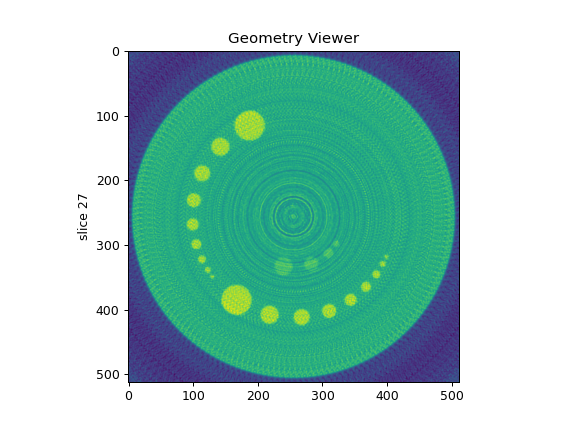

In [20]:
fig, ax = plt.subplots(1, 1)

tracker = IndexTracker(ax, im2.T)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [31]:
images2 = 200*np.tile(np.mean(np.flip(images[:,:,:],0),1),[128,1,1]).transpose([1,0,2])

<IPython.core.display.Javascript object>


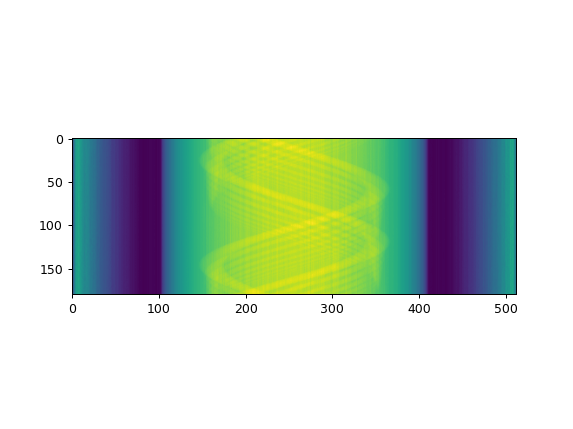

In [23]:
plt.figure()
plt.imshow(images2[:,1,:])

In [24]:
# keep it in low

for ii in range(images2.shape[1]):
    
    images2[:,ii,:] = remove_stripe(images2[:,ii,:],1,wname='db30')

<IPython.core.display.Javascript object>


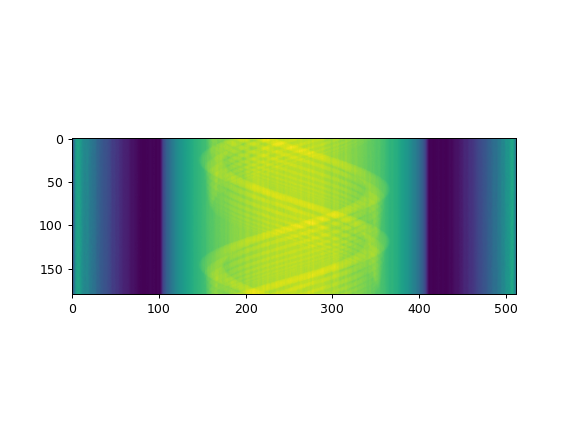

In [25]:
plt.figure()
plt.imshow(images2[:,1,:])

In [32]:
# im3 = tigre.algorithms.ossart(images2.astype(float32),geomet,angles,niter=50)
im3 = tigre.algorithms.FDK(images2.astype(float32),geomet,angles,filter="hamming")

<IPython.core.display.Javascript object>


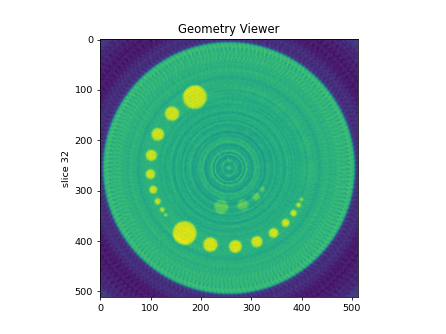

In [33]:
fig, ax = plt.subplots(1, 1)

tracker = IndexTracker(ax, im3.T)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [30]:
np.save('FDK_topas_simulation_noise_reduced',im3.T)

<IPython.core.display.Javascript object>


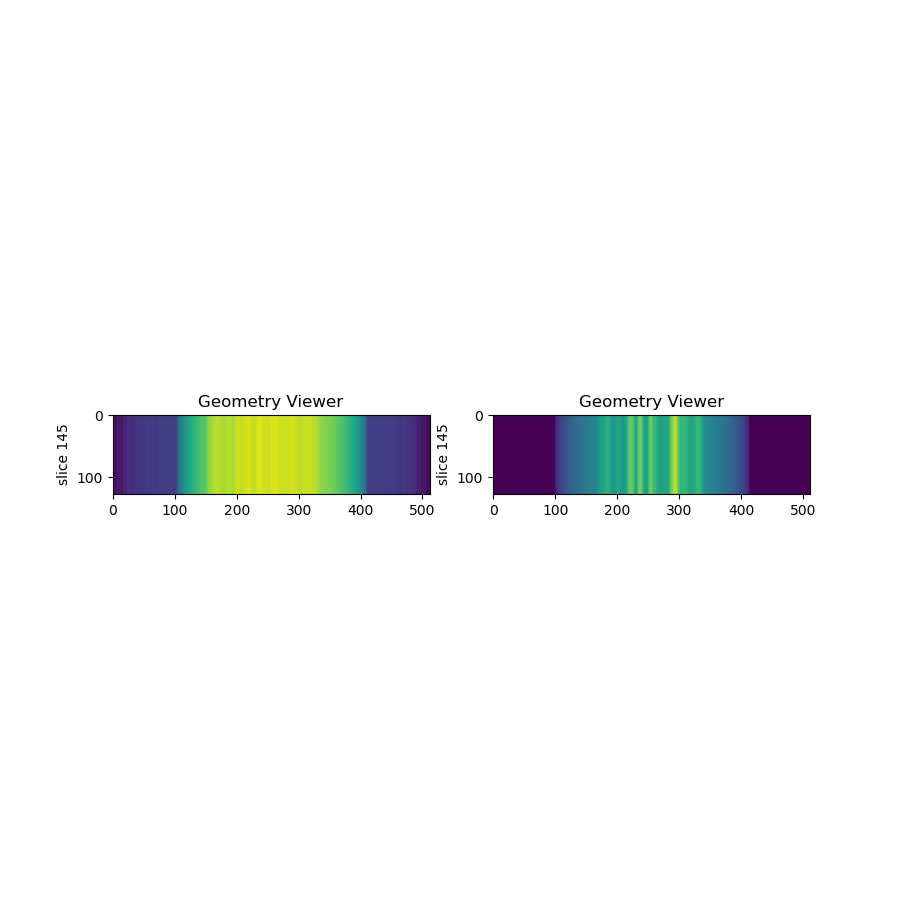

In [71]:
fig = plt.figure(figsize=[9,9])

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

tracker1 = IndexTracker(ax1, 10*rot90(np.tile(np.mean(images[:,:,:],1),[128,1,1]).transpose([1,0,2]).T))#transpose([0,2,1]))
tracker2 = IndexTracker(ax2, rot90(projs.T))


fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
plt.show()

<IPython.core.display.Javascript object>


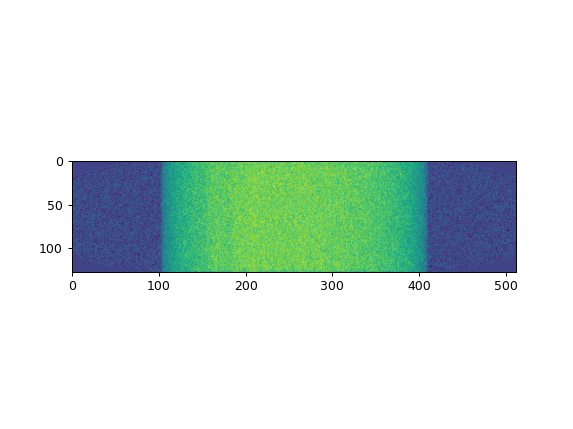

In [128]:
plt.figure()
plt.imshow(flood_128 - topas2numpy.BinnedResult(file).data['Sum'].squeeze().T)